<a href="https://colab.research.google.com/github/rdose/ia3-hunger_games/blob/main/Hunger_games_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [296]:
import pandas as pd
from sklearn.model_selection import train_test_split

url = "hunger_data.csv"
dataframe = pd.read_csv(url, header=0)
dataframe.drop("Unnamed: 0", axis=1, inplace=True)
dataframe.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron", "type_of_glass"]

In [297]:
import numpy as np
np.random.seed(989)

In [298]:
print("Data Sanity Check")
print(" -NULLs found =", dataframe.isnull().sum().sum()) # Check nulls
print(" -NANs found =", dataframe.isna().sum().sum()) # Check nan
tog = sorted(dataframe.type_of_glass.unique())
print(" -Classes:", tog)
print("    -totals:")
print(dataframe.groupby("type_of_glass").count().iron) #iron just because, it doesn't matter, all columns will have the same counts
print("    -missing:",sorted(set(range(tog[0], tog[-1] + 1)).difference(tog)) )

Data Sanity Check
 -NULLs found = 0
 -NANs found = 0
 -Classes: [1, 2, 3, 5, 6, 7]
    -totals:
type_of_glass
1    41
2    36
3    10
5     8
6     6
7    16
Name: iron, dtype: int64
    -missing: [4]


In [299]:
def print_scores(model, X_train, X_test, Y_train, Y_test, model_name='[no name]'):
    import sklearn as sk
    Y_pred = model.predict(X_test)
    print(" "*15,model_name)
    print("Default score:","-"*70)
    print(" Train: %.3f" % ref_model.score(X_train, Y_train))
    print(" Test: %.3f" % ref_model.score(X_test, Y_test))
    print("Other scores:","-"*70)
    print(" Accuracy  : %.3f" % sk.metrics.accuracy_score(Y_test,Y_pred))
    print(" "*12,ref_model.classes_)
    print(" Precision :",sk.metrics.precision_score(Y_test,Y_pred,average=None))
    print(" Recall    :",sk.metrics.recall_score(Y_test,Y_pred,average=None))
    print(" F1        :",sk.metrics.f1_score(Y_test,Y_pred,average=None))
    print(" F1 micro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='micro'))
    print(" F1 macro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='macro'))
    print(" Balanced accuracy: %.3f" % sk.metrics.balanced_accuracy_score(Y_test,Y_pred))
    print("-"*85)

In [300]:
def plot_roc(model, X_test, Y_test):
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    from scipy import interp
    import matplotlib.pyplot as plt
    from itertools import cycle


    # Let's binarise the classes
    from sklearn.preprocessing import label_binarize
    new_probs = label_binarize(Y_test, classes=[1, 2, 3, 5, 6, 7])

#df_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'threshold':thresholds})

    y_score = model.predict_proba(X_test) #model.decision_function(X_test)
    n_classes = len(model.classes_)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(new_probs[:, i], list(model.predict_proba(X_test)[:, i]), drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(new_probs.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'limegreen', 'darkorchid', 'peru'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(model.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [301]:
X = dataframe.drop(columns="type_of_glass") #Features
Y = dataframe["type_of_glass"] #Target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

#Normalise features wrt train. Not quite needed for decision tree but needed for some of the other algorithms
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

                [ Logistic regression (benchmark)]
Default score: ----------------------------------------------------------------------
 Train: 0.736
 Test: 0.533
Other scores: ----------------------------------------------------------------------
 Accuracy  : 0.533
             [1 2 3 5 6 7]
 Precision : [0.46666667 0.4        0.         0.25       1.         1.        ]
 Recall    : [0.875      0.2        0.         1.         0.66666667 0.8       ]
 F1        : [0.60869565 0.26666667 0.         0.4        0.8        0.88888889]
 F1 micro  : 0.533
 F1 macro  : 0.494
 Balanced accuracy: 0.590
-------------------------------------------------------------------------------------


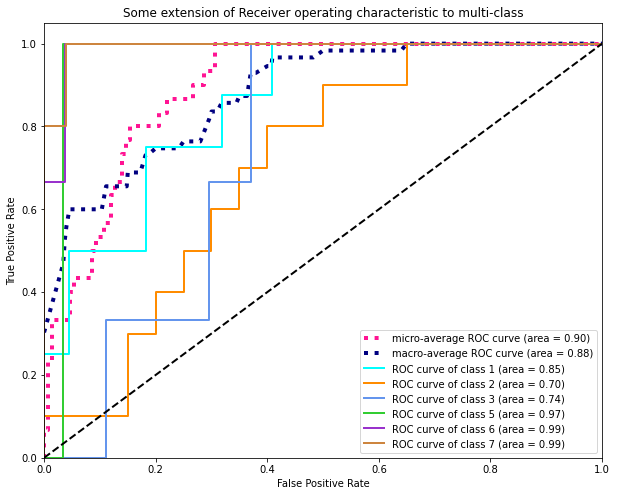

In [302]:

from sklearn.linear_model import LogisticRegression
ref_model = LogisticRegression(C=1).fit(X_train, Y_train)

print_scores(ref_model,X_train, X_test, Y_train, Y_test, '[ Logistic regression (benchmark)]')
plot_roc(ref_model, X_test, Y_test)

In [303]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from math import log10


param_grid = {'C': np.arange(0.8,1.1,0.01)}
model = LogisticRegression()
cv = GridSearchCV(model, param_grid, scoring="balanced_accuracy", cv=11)
cv.fit(X_train, Y_train)
cv.best_estimator_

LogisticRegression(C=0.8200000000000001)

                [ Decision tree]
Default score: ----------------------------------------------------------------------
 Train: 0.736
 Test: 0.533
Other scores: ----------------------------------------------------------------------
 Accuracy  : 0.633
             [1 2 3 5 6 7]
 Precision : [0.75       0.63636364 0.         0.33333333 0.         0.625     ]
 Recall    : [0.75 0.7  0.   1.   0.   1.  ]
 F1        : [0.75       0.66666667 0.         0.5        0.         0.76923077]
 F1 micro  : 0.633
 F1 macro  : 0.448
 Balanced accuracy: 0.575
-------------------------------------------------------------------------------------


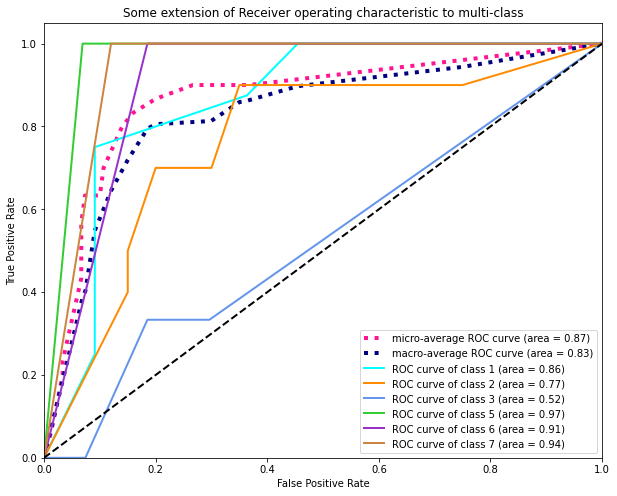

In [304]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy", max_depth=15, min_samples_leaf=7).fit(X_train, Y_train)

print_scores(model,X_train, X_test, Y_train, Y_test, '[ Decision tree]')
plot_roc(model, X_test, Y_test)

                [ Random forest]
Default score: ----------------------------------------------------------------------
 Train: 0.736
 Test: 0.533
Other scores: ----------------------------------------------------------------------
 Accuracy  : 0.700
             [1 2 3 5 6 7]
 Precision : [0.63636364 0.625      1.         0.33333333 1.         1.        ]
 Recall    : [0.875      0.5        0.33333333 1.         0.66666667 1.        ]
 F1        : [0.73684211 0.55555556 0.5        0.5        0.8        1.        ]
 F1 micro  : 0.700
 F1 macro  : 0.682
 Balanced accuracy: 0.729
-------------------------------------------------------------------------------------


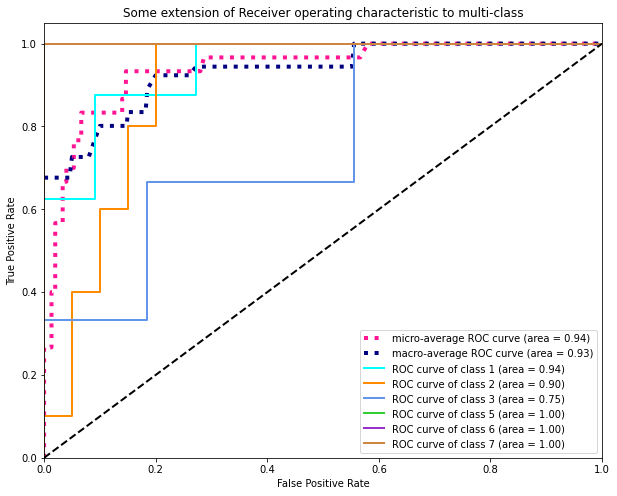

In [305]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=32, min_samples_split=3, n_estimators=80).fit(X_train, Y_train)

print_scores(model,X_train, X_test, Y_train, Y_test, '[ Random forest]')
plot_roc(model, X_test, Y_test)

In [306]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from math import log10
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score

scoring = {'f1_micro': 'f1_micro', 'balanced_accuracy': make_scorer(balanced_accuracy_score)}

param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [5, 10, 20], 'min_samples_split': [5, 10, 15, 20]}
param_grid2 = {'min_samples_split' : np.arange(2,10,1), 'max_depth': np.arange(30,34,1)}
model = RandomForestClassifier()
cv = GridSearchCV(model, param_grid2, scoring=scoring, refit='balanced_accuracy', return_train_score=True)
cv.fit(X_train, Y_train)
cv.best_estimator_

RandomForestClassifier(max_depth=33, min_samples_split=4)

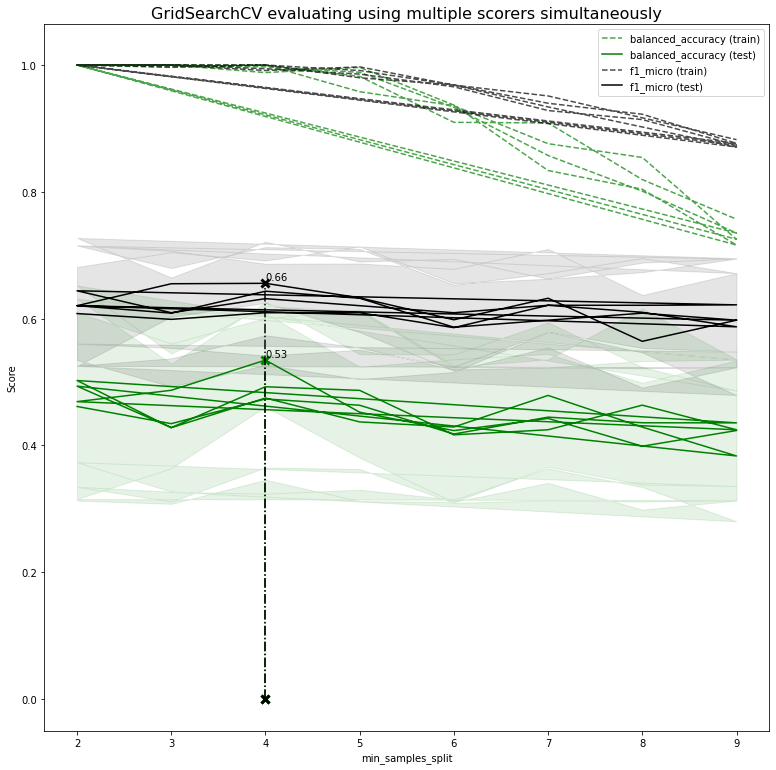

In [307]:
import matplotlib.pyplot as plt
results = cv.cv_results_
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()